In [1]:
!pip install python-igraph
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install easygui
!pip install cairocffi
!pip install pm4py


In [2]:
import igraph as ig
import easygui
from matplotlib import pyplot as plt
import numpy as np
import scipy
import statistics
import pandas as pd
import pm4py


In [22]:
#read data
transactions = pd.read_csv('TRANSACTION1.csv', sep=';')
#event_log = pd.read_csv('eventlog.csv', sep=';')

In [ ]:
#join transactions with event log
network_df = pd.merge(event_log, transactions, left_on=['TID'], right_on=['TID'], how='inner')


In [23]:
#network_df=network_df[network_df["Activity"]=="Settling"]
# Grouping by 'FromParticipantId' and 'ToParticipantId' and then summing the 'Value' column
summed_values = network_df.groupby(['FromParticipantId', 'ToParticipantId'])['Value'].sum().reset_index()

# Create a DataFrame containing all possible sender-receiver combinations
senders = network_df['FromParticipantId'].unique()
receivers = network_df['ToParticipantId'].unique()
all_combinations = pd.DataFrame([(sender, receiver) for sender in senders for receiver in receivers], columns=['FromParticipantId', 'ToParticipantId'])

# Left join the summed_values DataFrame with all_combinations DataFrame
summed_values = pd.merge(all_combinations, summed_values, on=['FromParticipantId', 'ToParticipantId'], how='left').fillna(0)
print(network_df)
print(summed_values)

       TID                 Time         Value  FromParticipantId  \
0        1  2024-03-02 00:20:21  7.352891e+07                  6   
1        2  2024-03-02 00:40:53  3.420816e+08                  2   
2        3  2024-03-02 01:22:31  7.284038e+07                  7   
3        4  2024-03-02 01:31:05  1.410661e+08                  8   
4        5  2024-03-02 01:33:01  2.056584e+08                  8   
...    ...                  ...           ...                ...   
2995  2996  2024-03-10 23:08:34  4.107530e+08                  4   
2996  2997  2024-03-10 23:12:19  7.888172e+07                  7   
2997  2998  2024-03-10 23:12:55  5.928171e+07                  4   
2998  2999  2024-03-10 23:17:08  5.871057e+07                  3   
2999  3000  2024-03-10 23:27:11  1.545063e+08                  2   

      FromAccountId  ToParticipantId  ToAccountId  Linkcode  \
0                 0                2            0       387   
1                 5                4            5       2

# 1 edge = 1 transaction

Participant 10 - In-degree: 126, Out-degree: 86
Participant 11 - In-degree: 84, Out-degree: 94
Participant 7 - In-degree: 113, Out-degree: 89
Participant 17 - In-degree: 148, Out-degree: 96
Participant 16 - In-degree: 100, Out-degree: 102
Participant 6 - In-degree: 73, Out-degree: 94
Participant 8 - In-degree: 125, Out-degree: 92
Participant 0 - In-degree: 1, Out-degree: 81
Participant 9 - In-degree: 64, Out-degree: 91
Participant 13 - In-degree: 69, Out-degree: 104
Participant 19 - In-degree: 25, Out-degree: 108
Participant 12 - In-degree: 94, Out-degree: 94
Participant 18 - In-degree: 154, Out-degree: 86
Participant 14 - In-degree: 94, Out-degree: 95
Participant 15 - In-degree: 74, Out-degree: 94
Participant 5 - In-degree: 46, Out-degree: 94
Participant 2 - In-degree: 36, Out-degree: 0
Participant 1 - In-degree: 38, Out-degree: 0
Participant 4 - In-degree: 32, Out-degree: 0
Participant 3 - In-degree: 4, Out-degree: 0


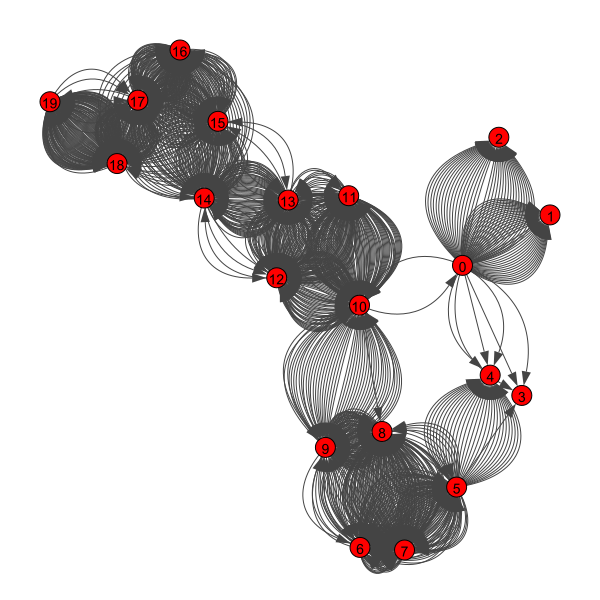

In [50]:
import pandas as pd
from igraph import Graph, plot
import matplotlib.pyplot as plt
import numpy as np

# Load data from CSV
transactions = pd.read_csv('TRANSACTION1.csv', sep=';')
df = transactions[(transactions['FromAccountId'] != 0) | (transactions['ToAccountId'] != 0)].copy()

# Extract unique participant IDs
participants = pd.DataFrame({
    'id': pd.concat([df['FromParticipantId'], df['ToParticipantId']]).unique()
})

# Create a graph with participants as nodes
g = Graph(directed=True)
g.add_vertices(participants['id'].astype(str))

# Add edges for each transaction
for _, row in df.iterrows():
    g.add_edge(str(row['FromParticipantId']), str(row['ToParticipantId']))

# Calculate in-degree and out-degree for each participant
in_degree = g.indegree()
out_degree = g.outdegree()

# Print results
for v in g.vs:
    print(f"Participant {v['name']} - In-degree: {in_degree[v.index]}, Out-degree: {out_degree[v.index]}")

# Visualize the graph
layout = g.layout('kk')  # Kamada-Kawai layout
visual_style = {
    "vertex_size": 20,
    "vertex_label": g.vs['name'],
    "edge_width": [1 for _ in g.es],  # Uniform edge width as weights are not considered
    "layout": layout,
    "bbox": (600, 600),
    "margin": 50
}
plot(g, **visual_style)


# edge = total value
### degree en visual klopt niet altijd zo te zien

DataFrame has been written to 'df_output.csv'
Empty DataFrame
Columns: [FromParticipantId, ToParticipantId, Value]
Index: []
Participant 11 - In-degree: 4, Out-degree: 4
Participant 15 - In-degree: 4, Out-degree: 5
Participant 16 - In-degree: 3, Out-degree: 4
Participant 3 - In-degree: 4, Out-degree: 5
Participant 9 - In-degree: 5, Out-degree: 5
Participant 8 - In-degree: 4, Out-degree: 4
Participant 2 - In-degree: 3, Out-degree: 3
Participant 10 - In-degree: 5, Out-degree: 4
Participant 19 - In-degree: 1, Out-degree: 2
Participant 5 - In-degree: 5, Out-degree: 5
Participant 13 - In-degree: 4, Out-degree: 5
Participant 4 - In-degree: 3, Out-degree: 4
Participant 12 - In-degree: 4, Out-degree: 4
Participant 7 - In-degree: 4, Out-degree: 4
Participant 14 - In-degree: 5, Out-degree: 5
Participant 0 - In-degree: 4, Out-degree: 5
Participant 6 - In-degree: 4, Out-degree: 4
Participant 17 - In-degree: 4, Out-degree: 5
Participant 1 - In-degree: 3, Out-degree: 0
Participant 18 - In-degree: 4,

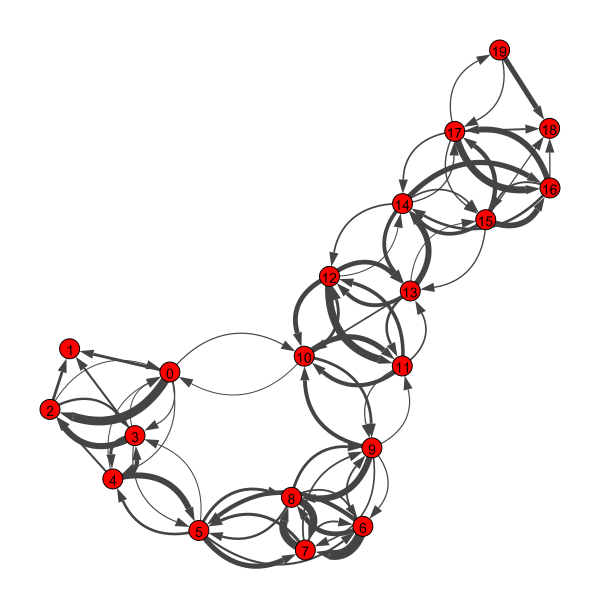

In [86]:
import pandas as pd
from igraph import Graph, plot
import numpy as np

# Load data from CSV
transactions = pd.read_csv('TRANSACTION1.csv', sep=';')
df = transactions[(transactions['FromAccountId'] != 0) | (transactions['ToAccountId'] != 0)].copy()

# Convert IDs to string right after filtering to maintain consistency
df['FromParticipantId'] = df['FromParticipantId'].astype(int).astype(str)
df['ToParticipantId'] = df['ToParticipantId'].astype(int).astype(str)

# Aggregate transaction values by pairs
transaction_sums = df.pivot_table(index=['FromParticipantId', 'ToParticipantId'], values='Value', aggfunc='sum').reset_index()
# Write DataFrame to a text file
transaction_sums.to_csv('df_output.csv', index=False) # Hier zit de fout niet

# Print confirmation message
print("DataFrame has been written to 'df_output.csv'")
filtered_transactions = transaction_sums[(transaction_sums['FromParticipantId'] == 18) & (transaction_sums['ToParticipantId'] == 19)]
print(filtered_transactions)
# Extract unique participant IDs and ensure they are strings
participants = pd.DataFrame({
    'id': pd.concat([df['FromParticipantId'], df['ToParticipantId']]).unique()
})

# Create a graph with participants as nodes, ensuring all are strings
g = Graph(directed=True)
g.add_vertices(participants['id'].tolist())

# Add aggregated edges, ensuring consistency in string usage
for _, row in transaction_sums.iterrows():
    try:
        g.add_edge(row['FromParticipantId'], row['ToParticipantId'], weight=row['Value'])
    except ValueError as e:
        print(f"Error adding edge from {row['FromParticipantId']} to {row['ToParticipantId']}: {e}")

# Calculate in-degree and out-degree for each participant
in_degree = g.indegree()
out_degree = g.outdegree()

# Print results
for v in g.vs:
    print(f"Participant {v['name']} - In-degree: {in_degree[v.index]}, Out-degree: {out_degree[v.index]}")


# Normalize edge weights for visualization
weights = np.array(g.es["weight"])
normalized_weights = 1 + 9 * (weights - weights.min()) / (weights.max() - weights.min())

# Visualize the graph
layout = g.layout('kk')  # Kamada-Kawai layout
visual_style = {
    "vertex_size": 20,
    "vertex_label": g.vs['name'],
    "edge_width": normalized_weights,  # Adjust edge width scaling as needed
    "layout": layout,
    "bbox": (600, 600),
    "margin": 50
}
plot(g, **visual_style)


## Proberen om visual met heatmap te maken maar nog niet gelukt

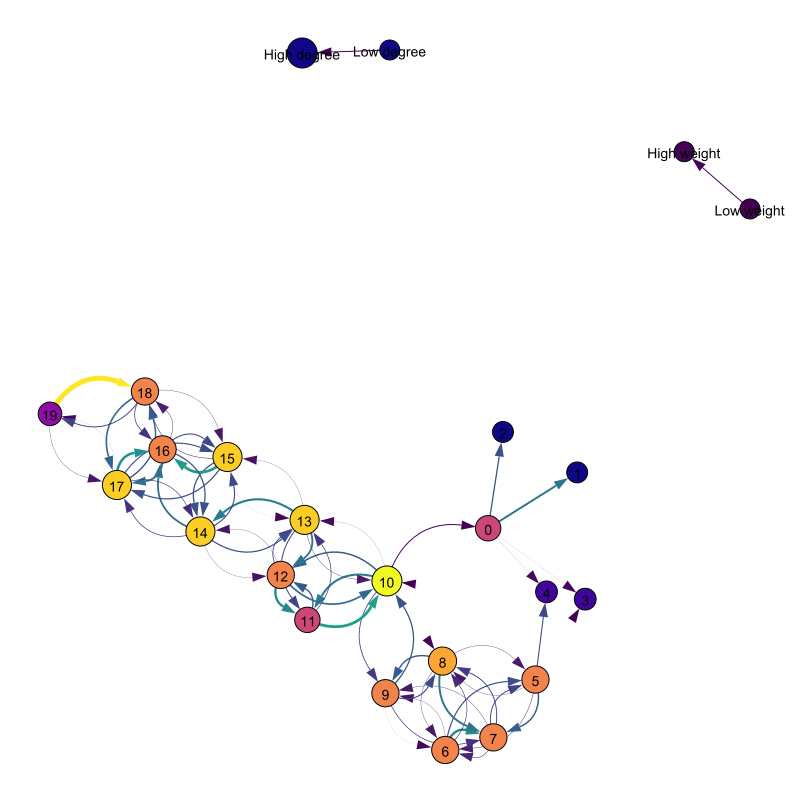

In [73]:
import pandas as pd
from igraph import Graph, plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors  # Correct import for color handling

# Load data from CSV
transactions = pd.read_csv('TRANSACTION1.csv', sep=';')
df = transactions[(transactions['FromAccountId'] != 0) | (transactions['ToAccountId'] != 0)].copy()

# Convert IDs to string right after filtering to maintain consistency
df['FromParticipantId'] = df['FromParticipantId'].astype(int).astype(str)
df['ToParticipantId'] = df['ToParticipantId'].astype(int).astype(str)

# Aggregate transaction values by pairs
transaction_sums = df.groupby(['FromParticipantId', 'ToParticipantId']).agg({
    'Value': 'sum'
}).reset_index()

# Extract unique participant IDs and ensure they are strings
participants = pd.DataFrame({
    'id': pd.concat([df['FromParticipantId'], df['ToParticipantId']]).unique()
})

# Create a graph with participants as nodes, ensuring all are strings
g = Graph(directed=True)
g.add_vertices(participants['id'].tolist())

# Add aggregated edges, ensuring consistency in string usage
for _, row in transaction_sums.iterrows():
    g.add_edge(row['FromParticipantId'], row['ToParticipantId'], weight=row['Value'])

# Calculate degrees for vertex size and color scaling
degrees = g.degree()
max_degree = max(degrees)
vertex_sizes = [20 + 10 * (deg / max_degree) for deg in degrees]
degree_normalized = (np.array(degrees) - min(degrees)) / (max(degrees) - min(degrees))

# Normalize edge weights for visualization
weights = np.array(g.es["weight"])
normalized_weights = (weights - weights.min()) / (weights.max() - weights.min())
edge_colors = plt.cm.viridis(normalized_weights)
vertex_colors = plt.cm.plasma(degree_normalized)

# Convert color arrays to hex codes or tuples
edge_colors = [mcolors.rgb2hex(color) for color in edge_colors]
vertex_colors = [mcolors.rgb2hex(color) for color in vertex_colors]

# Adding legend elements
legend_vertices = ['Low degree', 'High degree', 'Low weight', 'High weight']
g.add_vertices(legend_vertices)
legend_colors = [mcolors.rgb2hex(plt.cm.plasma(0)), mcolors.rgb2hex(plt.cm.plasma(1)),
                 mcolors.rgb2hex(plt.cm.viridis(0)), mcolors.rgb2hex(plt.cm.viridis(1))]
legend_sizes = [20, 30, 20, 20]
legend_edges = [(legend_vertices[0], legend_vertices[1]), (legend_vertices[2], legend_vertices[3])]
g.add_edges(legend_edges)
edge_indices = [g.get_eid(legend_vertices[0], legend_vertices[1]), g.get_eid(legend_vertices[2], legend_vertices[3])]
for i in edge_indices:
    g.es[i]['width'] = 1

# Update visual style for the legend
visual_style = {
    "vertex_size": vertex_sizes + legend_sizes,
    "vertex_color": vertex_colors + legend_colors,
    "vertex_label": list(g.vs['name']) + legend_vertices,
    "edge_width": list(normalized_weights * 5) + [1, 1],  # Ensure correct list length and type
    "edge_color": list(edge_colors) + [mcolors.rgb2hex(plt.cm.viridis(0)), mcolors.rgb2hex(plt.cm.viridis(1))],
    "layout": g.layout('kk'),  # Kamada-Kawai layout
    "bbox": (800, 800),  # Increased the bounding box size
    "margin": 50
}

plot(g, **visual_style)


In [77]:
#print basic network statistics
betw=g.betweenness()
print(betw)
degree=g.degree()
print(degree)
closeness=g.closeness()
print(closeness)
pagerank=g.pagerank()
print(pagerank)
avg_path=g.average_path_length()
print(avg_path)
clustering_coeff=g.transitivity_undirected()
print(clustering_coeff)

[53.3073593073593, 30.476190476190474, 1.5833333333333333, 15.538528138528141, 74.58961038961039, 6.8632034632034635, 0.3333333333333333, 110.85930735930737, 0.0, 27.999999999999993, 71.97510822510824, 6.705194805194805, 60.44155844155844, 6.8632034632034635, 67.77380952380952, 74.24372294372294, 6.8632034632034635, 34.583333333333336, 0.0, 0.0]
[8, 9, 7, 9, 10, 8, 6, 9, 3, 10, 9, 7, 8, 8, 10, 9, 8, 9, 3, 4]
[0.4318181818181818, 0.36538461538461536, 0.2923076923076923, 0.35185185185185186, 0.3958333333333333, 0.3392857142857143, 0.3275862068965517, 0.48717948717948717, 0.2345679012345679, 0.3064516129032258, 0.4418604651162791, 0.34545454545454546, 0.4222222222222222, 0.3392857142857143, 0.36538461538461536, 0.40425531914893614, 0.3392857142857143, 0.296875, 0.3220338983050847, 0.2878787878787879]
[0.05786088180643984, 0.042941654544305805, 0.034280779960476036, 0.04966826586189664, 0.07582679740972186, 0.06093908701601463, 0.03647173237455184, 0.06512825297097682, 0.01799349904497615,